# Deep Q-Learning para _lunar lander_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---
Ejemplo basado en:
> Udacity (2019) Deep Reinforcement Learning Course. Disponible en [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).

In [1]:
import gfootball.env as football_env
from dqn_agent_simultaneous_update import Agent
from gfootball.env import football_action_set

env = football_env.create_environment(
    env_name='academy_run_to_score', 
    stacked=False,                           # solo estado, no pixeles 
    representation='simple115',              # solo estado, no pixeles 
    rewards='scoring,checkpoints',           # recompensas intermedias, no solo al marcar Currently supported rewards are 'scoring' and 'checkpoints'.
    render=False)                            # mostrar graficamente

agent = Agent(state_size=115, action_size=21, seed=0)

/home/luciano/anaconda3/envs/football/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luciano/anaconda3/envs/football/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luciano/anaconda3/envs/football/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luciano/anaconda3/envs/football

## Algoritmo
A continuación se proporciona una implementación genérica del algoritmo Deep Q-Learning (DQN) y su aplicación a [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/).

Se considera que el entorno [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) está resuelto cuando se obtienen más de $200$ puntos de media durante 100 episodios consecutivos.

In [2]:
import logging, os
logging.disable(logging.WARNING)

In [3]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Episodio 50	Puntuacion media (50 anteriores): 0.08
Episodio 100	Puntuacion media (50 anteriores): 0.19
Episodio 150	Puntuacion media (50 anteriores): 0.11
Episodio 200	Puntuacion media (50 anteriores): 0.02
Episodio 250	Puntuacion media (50 anteriores): -0.03
Episodio 300	Puntuacion media (50 anteriores): 0.13
Episodio 350	Puntuacion media (50 anteriores): 0.38
Episodio 400	Puntuacion media (50 anteriores): 0.43
Episodio 450	Puntuacion media (50 anteriores): 0.30
Episodio 500	Puntuacion media (50 anteriores): 0.27
Episodio 550	Puntuacion media (50 anteriores): 0.42
Episodio 600	Puntuacion media (50 anteriores): 0.41
Episodio 650	Puntuacion media (50 anteriores): 0.41
Episodio 700	Puntuacion media (50 anteriores): 0.40
Episodio 750	Puntuacion media (50 anteriores): 0.25
Episodio 800	Puntuacion media (50 anteriores): 0.26
Episodio 850	Puntuacion media (50 anteriores): 0.29
Episodio 900	Puntuacion media (50 anteriores): 0.24
Episodio 950	Puntuacion media (50 anteriores): 0.31
Episodio 100

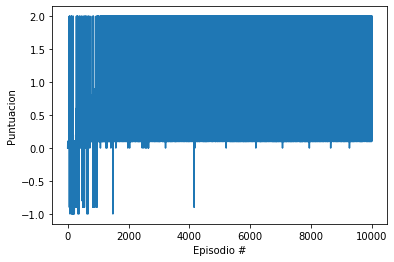

In [4]:
def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): numero maximo de episodios de entrenamiento (n_episodios)
        max_t (int): numero maximo de pasos por episodio (n_entrenamiento)
        eps_start (float): valor inicial de epsilon
        eps_end (float): valor final de epsilon
        eps_decay (float): factor de multiplicacion (por episodio) de epsilon
    """
    scores = []                        # puntuaciones de cada episodio
    scores_window = deque(maxlen=50)  # puntuaciones de los ultimos 100 episodios
    eps = eps_start                    # inicializar epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            
            # elegir accion At con politica e-greedy
            action = agent.act(state, eps)
            
            # aplicar At y obtener Rt+1, St+1
            next_state, reward, done, _ = env.step(action)
            
            # almacenar <St, At, Rt+1, St+1>
            agent.memory.add(state, action, (reward * 10) ** 3, next_state, done)
            
            # train & update
            agent.step(state, action, reward, next_state, done)
            
            # avanzar estado
            state = next_state
            score += reward
            
            if done:
                break 

        scores_window.append(score)       # guardar ultima puntuacion
        scores.append(score)              # guardar ultima puntuacion
        eps = max(eps_end, eps_decay*eps) # reducir epsilon
        
        #print('\rEpisodio {}\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode, 50, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisodio {}\tPuntuacion media ({:d} anteriores): {:.2f}'.format(i_episode, 50, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # guardar pesos de agente entrenado
        if np.mean(scores_window)>=2.0:
            print('\nProblema resuelto en {:d} episodios!\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode-50, 50, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # guardar pesos de agente entrenado
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()